**About** : This notebook is used to prepare the data.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ../src/

/home/tviel/work/kaggle_birdclef_2024/src


/home/tviel/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Imports

In [4]:
import os
import sys
import glob
import json
import torch
import librosa
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
from joblib import delayed
from sklearn.metrics import *

warnings.simplefilter(action="ignore", category=UserWarning)

In [5]:
from params import *
from util.plots import *

from data.preparation import prepare_data, prepare_xenocanto_data
from data.dataset import WaveDataset
from data.transforms import get_transfos

from util.logger import create_logger, save_config, prepare_log_folder
from util.torch import init_distributed

from model_zoo.models import define_model
from model_zoo.melspec import FeatureExtractor, CustomTimeMasking, CustomFreqMasking

from training.losses import BirdLoss
from training.main import k_fold

### Data

In [6]:
df = prepare_data()
# df_xc = prepare_xenocanto_data()

df.sample(5)

,id,filename,primary_label,secondary_labels,rating,path,path_ft,fold
18990,XC752678,plapri1/XC752678.ogg,plapri1,[],4.5,../input/train_audio/plapri1/XC752678.ogg,../input/train_features/plapri1/XC752678.hdf5,0
22123,XC285234,tilwar1/XC285234.ogg,tilwar1,[],4.0,../input/train_audio/tilwar1/XC285234.ogg,../input/train_features/tilwar1/XC285234.hdf5,3
5412,XC571420,comior1/XC571420.ogg,comior1,[],4.0,../input/train_audio/comior1/XC571420.ogg,../input/train_features/comior1/XC571420.hdf5,2
16154,XC802905,labcro1/XC802905.ogg,labcro1,[],3.5,../input/train_audio/labcro1/XC802905.ogg,../input/train_features/labcro1/XC802905.hdf5,2
12124,XC845838,grewar3/XC845838.ogg,grewar3,[],4.0,../input/train_audio/grewar3/XC845838.ogg,../input/train_features/grewar3/XC845838.hdf5,1


In [7]:
transforms = get_transfos(augment=True, strength=1)

In [9]:
dataset = WaveDataset(
    df,
    transforms,
    max_len=32000 * 10,
    train=True,
    self_mixup=True,
)

In [8]:
# for i in tqdm(range(len(dataset))):
#     # try:
#     x = dataset[i]
#     # except:
#     #     print(i)
#     #     break

In [9]:
wave, y, w = dataset[np.random.choice(len(dataset))]
# w = wave

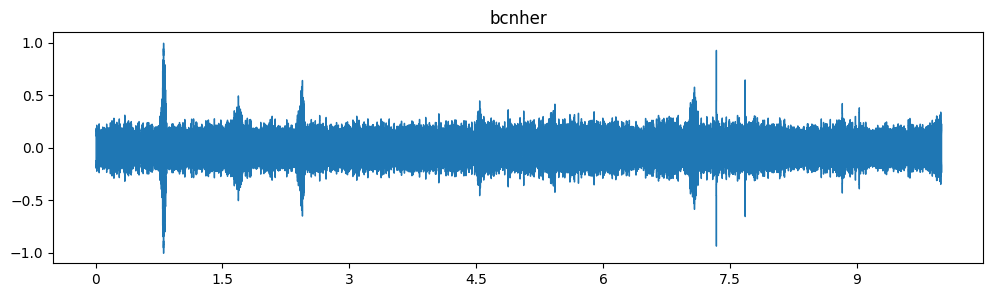

In [10]:
display_audio(wave.numpy(), title=", ".join(([CLASSES[int(c)] for c in np.argwhere(y.numpy())[0]])))

In [11]:
# display_audio(w.numpy(), title=", ".join(([CLASSES[int(c)] for c in np.argwhere(y.numpy())[0]])))

### Spectrograms

In [34]:
params = {
    "sample_rate": 32000,
    "n_mels": 128,
    "f_min": 50,
    "f_max": 15000,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": False,
}

aug_config = {
    "specaug_freq": {
        "mask_max_length": 10,
        "mask_max_masks": 3,
        "p": 0.,
    },
    "specaug_time": {
        "mask_max_length": 20,
        "mask_max_masks": 3,
        "p": 0.,
    },
    "mixup":
    {
        "p_audio": 0,
        "p_spec": 0,
        "additive": True,
        "alpha": 4,
        "num_classes": 182,
    }
}

In [35]:
ft_extractor = FeatureExtractor(params, aug_config=aug_config)
ft_extractor = ft_extractor.train()

In [36]:
x = torch.stack([wave, wave])
if len(y.size()) < 2:
    y = torch.stack([y, y])

In [37]:
melspec, _, _ = ft_extractor(x)

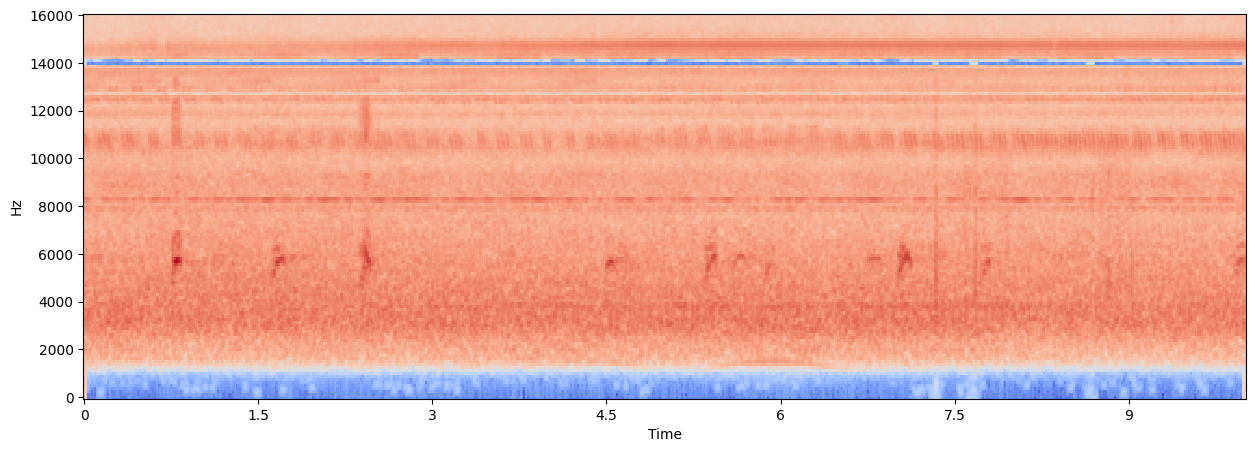

In [38]:
plot_spectrogram(melspec[0].numpy(), params)

In [39]:
# plot_spectrogram(melspec[1].numpy(), params)

### Model

In [40]:
model = define_model(
    "eca_nfnet_l0", 
    params,
    head="gem",
    n_channels=1,
    num_classes=NUM_CLASSES,
)

In [43]:
pred, _, _ = model(x, y)

In [44]:
y.size(), pred.size()

(torch.Size([2, 182]), torch.Size([2, 182]))

In [45]:
loss = BirdLoss({"name": "bce", "top_k": 0})
loss(pred, y)

tensor(0.7305, grad_fn=<MeanBackward0>)

### Train

In [46]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    device = "cuda"
    save_weights = True

    # Data
    train_duration = 5
    duration = 5
    aug_strength = 0
    self_mixup = True
    normalize = True

    melspec_config = {
        "sample_rate": 32000,
        "n_mels": 128,  # 128, 224
        "f_min": 50,
        "f_max": 15000,
        "n_fft": 2048,
        "hop_length": 512,  # 716, 512, 417
        "normalized": False,
    }

    aug_config = {
        "specaug_freq": {
            "mask_max_length": 10,
            "mask_max_masks": 3,
            "p": 0.5,
        },
        "specaug_time": {
            "mask_max_length": 20,
            "mask_max_masks": 3,
            "p": 0.5,
        },
        "mixup":
        {
            "p_audio": 0.75,
            "p_spec": 0.25,
            "additive": True,
            "alpha": 4,
            "num_classes": 182,
        }
    }

    # k-fold
    k = 4
    folds_file = f"../input/folds_{k}.csv"
    selected_folds = [0, 1, 2, 3]

    # Model
    name = "tf_efficientnetv2_s"  # tf_efficientnetv2_s maxvit_tiny_tf_384 eca_nfnet_l0
    pretrained_weights = None

    num_classes = 182
    drop_rate = 0.2
    drop_path_rate = 0.2
    n_channels = 1
    head = "gem"
    reduce_stride = "256" in name

    # Training
    loss_config = {
        "name": "bce",
        "weighted": True,
        "smoothing": 0.,
        "top_k": 0,
        "activation": "sigmoid",  # "softmax"
    }
    secondary_labels_weight = 1. if loss_config["name"] == "bce" else 0.5  # 0.5 for ce / 1. for bce

    data_config = {
        "batch_size": 64,
        "val_bs": 256,
        "num_classes": num_classes,
        "num_workers": 8,
    }

    optimizer_config = {
        "name": "Ranger",
        "lr": 5e-3,
        "warmup_prop": 0.0,
        "betas": (0.9, 0.999),
        "max_grad_norm": 0.1,
        "weight_decay": 0.,
    }

    epochs = 20

    use_fp16 = True
    verbose = 1
    verbose_eval = 20

    fullfit = True
    n_fullfit = 1

In [47]:
DEBUG = True

In [48]:
log_folder = None
config = Config

if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f'\n -> Logging results to {log_folder}\n')

    create_logger(directory=log_folder, name="logs.txt")
    save_config(config, log_folder + "config.json")

init_distributed(config)

- Training with one GPU.


In [49]:
df = prepare_data(DATA_PATH)
# df_xc = prepare_xenocanto_data(DATA_PATH)
# df = pd.concat([df, df_xc], ignore_index=True)

# if DEBUG:
#     df = df.sample(100).reset_index(drop=True)

In [52]:
k_fold(config, df, log_folder=log_folder)


-------------   Fold 1 / 4  -------------

    -> 18345 training birdcalls
    -> 6114 validation birdcalls
    -> 20410222 trainable parameters

Epoch 01/20 (step 0020) 	lr=5.0e-03 	 t=11s 	 loss=0.499	 val_loss=0.041    auc=0.507    auc_s=0.507
Epoch 01/20 (step 0040) 	lr=5.0e-03 	 t=4s 	 loss=0.072	 val_loss=0.037    auc=0.574    auc_s=0.579
Epoch 01/20 (step 0060) 	lr=4.9e-03 	 t=4s 	 loss=0.064	 val_loss=0.036    auc=0.595    auc_s=0.598


KeyboardInterrupt: 

Done !